<a href="https://colab.research.google.com/github/celimo/Tarea4_IA/blob/main/Tarea4_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install control

In [2]:
import control as co # Trabajar sistemas de control
from control.matlab import * # Utilizar un entorno similar al de matlab
import numpy as np # Trabajar con matrices
import matplotlib.pyplot as plt # Imprimir resultados
import random # Generar números aleatorios

In [3]:
" Definición de la función de transferencia del sistema "

def fun_Tran(Inp):
  s = tf('s')

  A = Inp[0]
  B = Inp[1]
  C = Inp[2]
  D2 = Inp[3][0]
  F = Inp[4]
  K = Inp[5]

  G1 = (A[0]) / (B[0]*s**2 + B[0]*C[0]*s)
  G2 = (A[1]*s) / (B[1]*s**2 + B[1]*C[1] + D2)
  G3 = (A[2]*s**2 + A[2]*C[2]*s) / (B[2])

  H1 = F[0]*K[0]*s + K[0]
  H2 = F[1]*K[1]*s**2 + K[1]*s
  H3 = K[2]*s 

  num = G1*G2*G3 + G1*H1*G3
  den = 1 + G1*G2*G3 + G2*H2 + G2*H3 + H1*H3 + G1*H1*G3

  funct = num/den

  return funct


         3.707e+09 s^17 + 1.115e+11 s^16 + 1.404e+12 s^15 + 1.075e+13 s^14 + 6.445e+13 s^13 + 3.195e+14 s^12 + 1.248e+15 s^11 + 4.261e+15 s^10 + 1.226e+16 s^9 + 2.69e+16 s^8 + 6.058e+16 s^7 + 6.706e+16 s^6 + 1.201e+17 s^5 + 1.04e+16 s^4
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
4.448e+11 s^18 + 1.251e+13 s^17 + 1.502e+14 s^16 + 1.128e+15 s^15 + 6.709e+15 s^14 + 3.271e+16 s^13 + 1.269e+17 s^12 + 4.308e+17 s^11 + 1.217e+18 s^10 + 2.699e+18 s^9 + 5.862e+18 s^8 + 6.708e+18 s^7 + 1.131e+19 s^6 + 1.094e+18 s^5 + 1.538e+16 s^4



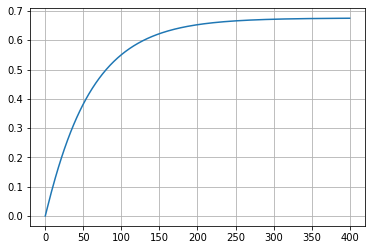

In [4]:
Cm = []

Cm.append([1,2,3])
Cm.append([4,5,6])
Cm.append([7,8,9])
Cm.append([10])
Cm.append([11,12])
Cm.append([13,14,15])

sys = fun_Tran(Cm)

print(sys)

t = np.linspace(0, 400, 1000)
t1, y1 = co.step_response(sys, t)

plt.plot(t1, y1)
plt.grid()
plt.show()

In [ ]:
'''
Definición del cromosoma

Cromosoma = [[A1, A2, A3], [B1, B2, B3], [C1, C2, C3], [D2], [F1, F2], [K1, K2, K3]]

Definición del gen: Cada elemento del cromosoma es un vector con dimensiones variables

Alelos: Como primera aproximación se consideran valores entre -10 y 10
'''

po

# Creación de la población

num_poblacion = 200

for i in range(num_poblacion):
